In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import StackingRegressor
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
power_consumption_of_tetouan_city = fetch_ucirepo(id=849) 
  
# data (as pandas dataframes) 
X = power_consumption_of_tetouan_city.data.features 
y = power_consumption_of_tetouan_city.data.targets 
  
# metadata 
print(power_consumption_of_tetouan_city.metadata) 
  
# variable information 
print(power_consumption_of_tetouan_city.variables) 


{'uci_id': 849, 'name': 'Power Consumption of Tetouan City', 'repository_url': 'https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city', 'data_url': 'https://archive.ics.uci.edu/static/public/849/data.csv', 'abstract': 'This dataset is related to power consumption of three different distribution networks of Tetouan city which is located in north Morocco.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 52417, 'num_features': 6, 'feature_types': ['Real', 'Integer'], 'demographics': [], 'target_col': ['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C5B034', 'creators': ['Abdulwahed Salam', 'Abdelaaziz El Hibaoui'], 'intro_paper': {'title': 'Comparison of Machine Learning Algorithms for the 

**Preprocessing**

In [4]:
#Convert the date_time column to a datetime datatype
X['DateTime'] = pd.to_datetime(X['DateTime'])

/var/folders/zt/tl4cjgsd5rzfpyy9y2vkgbyr0000gn/T/ipykernel_1672/4132265938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['DateTime'] = pd.to_datetime(X['DateTime'])


Examinze the different networks

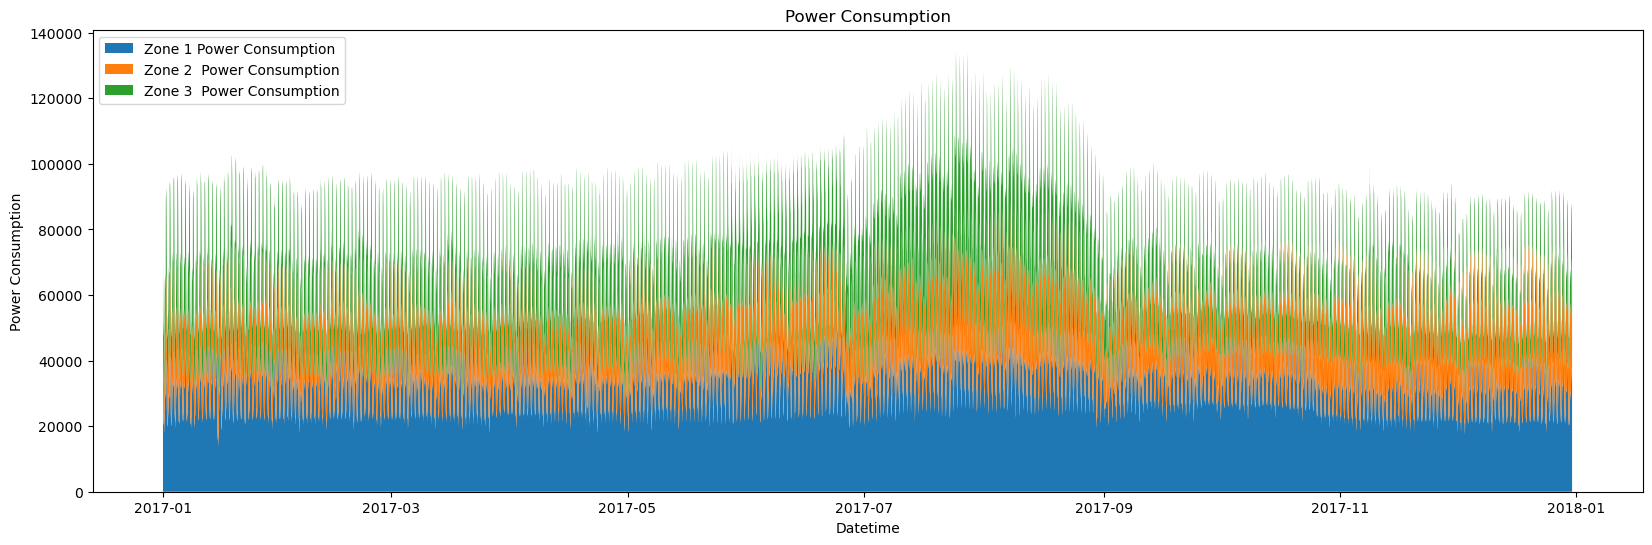

In [5]:
plt.figure(figsize=(20, 6))
plt.stackplot(X['DateTime'], y.T, labels=y.columns)
plt.legend(loc='upper left')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption')
plt.show()

Base on Fig 1 of paper, we can distinguish 3 different distribution network:

- Zone 1 = Boussafou (the lowest power consumption)

- Zone 2 = Smir

- Zone 3 = Quods (highest peak)

But the y value in the plot is much higher than the y value in the paper. Not sure do we use the same value with paper or not

In [6]:
#Extract the quater, month, weekdays, day, day of year, week of year, hour, and minute from the date_time column
X.loc[:, 'Month'] = X['DateTime'].dt.month
X.loc[:, 'Day'] = X['DateTime'].dt.day
X.loc[:, 'Hour'] = X['DateTime'].dt.hour
X.loc[:, 'Minute'] = X['DateTime'].dt.minute
X.loc[:, 'Weekdays'] = X['DateTime'].dt.weekday
X.loc[:, 'Quarter'] = X['DateTime'].dt.quarter
X.loc[:, 'DayOfYear'] = X['DateTime'].dt.dayofyear
X.loc[:, 'WeekOfYear'] = X['DateTime'].dt.isocalendar().week

# Drop the date_time column
X = X.drop('DateTime', axis = 1)

# Print X columns
print(X.columns)


Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Month', 'Day', 'Hour', 'Minute', 'Weekdays',
       'Quarter', 'DayOfYear', 'WeekOfYear'],
      dtype='object')


/var/folders/zt/tl4cjgsd5rzfpyy9y2vkgbyr0000gn/T/ipykernel_1672/909330328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Month'] = X['DateTime'].dt.month
/var/folders/zt/tl4cjgsd5rzfpyy9y2vkgbyr0000gn/T/ipykernel_1672/909330328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Day'] = X['DateTime'].dt.day


In [7]:
#Scale the data using the MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
y_scaler = scaler.fit_transform(y)

In [8]:
# Check feature importance using Random forest
forest = RandomForestRegressor(random_state=0)
forest.fit(X_scaler, y_scaler)

RandomForestRegressor(random_state=0)

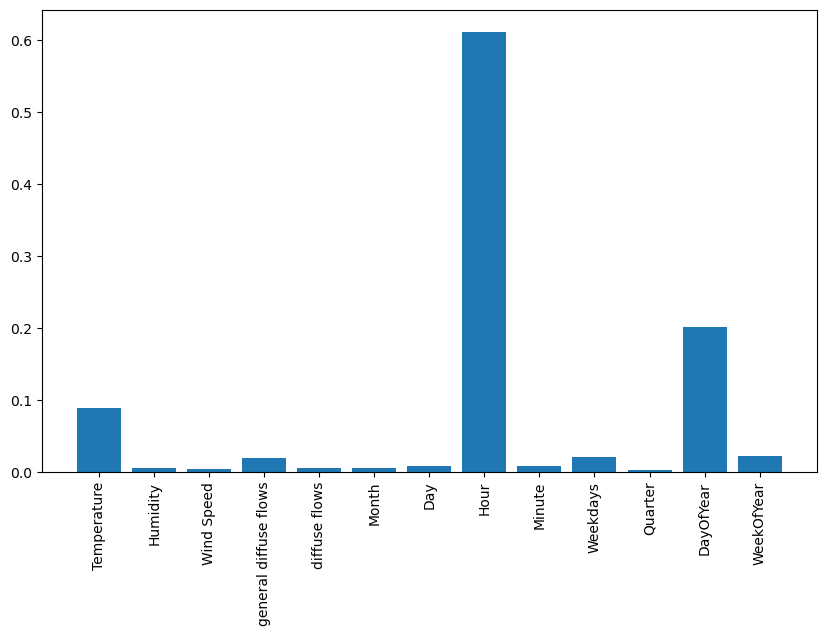

In [9]:
importances = forest.feature_importances_

#plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, importances)
plt.xticks(rotation='vertical')
plt.show()

Hour is still the most importance feature but the 2nd highest importance feature from my calculation is Day of year, which is different than paper (Temparature). I think it is because of the randomness of the bootstrapping of the samples used when building trees in random forest.

In [10]:
#Each algorithm is trained by using 75% of the data and 25% for testing
X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler = train_test_split(X_scaler, y_scaler, test_size = 0.25, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

**Train model**

Apply the best parameter for 5 models

10 minutes comparison

In [ ]:
#Random Forest Regressor
#The best values which are gotten by the grid search method were 30, 7, None, 2 and 1 for the number of trees and the number of features, max depth of the tree, min samples split and min sample leaf parameters respectively.
rf = RandomForestRegressor(n_estimators=30, max_features=7, min_samples_split=2, max_depth=None, min_samples_leaf=1, random_state=0)
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(X_train, y_train)
y_train_pred_rf = multi_rf.predict(X_train)
y_test_pred_rf = multi_rf.predict(X_test)

#Decision Tree Regressor
#The depth of the tree, the minimum number of samples required to split an internal node, the minimum number of samples required to be at a leaf node and the number of features to consider when looking for the best split. The best result of these parameters which were gotten by grid search were None, 10, 10 and 9 for the parameters above respectively
dt = DecisionTreeRegressor(max_depth=None, min_samples_split=10, min_samples_leaf=10, max_features=9, random_state=0)
multi_dt = MultiOutputRegressor(dt)
multi_dt.fit(X_train, y_train)
y_train_pred_dt = multi_dt.predict(X_train)
y_test_pred_dt = multi_dt.predict(X_test)

#Support Vector Regressor
#cost equals to 10 and when gamma equals to 0.01, support vector machine for regression (SVR) with radial basis function kernel.
svrclf = SVR(C=10, gamma=0.01, kernel="rbf")
multi_svr = MultiOutputRegressor(svrclf)
multi_svr.fit(X_train_scaler, y_train)
y_train_pred_svr = multi_svr.predict(X_train_scaler)
y_test_pred_svr = multi_svr.predict(X_test_scaler)

#Feedforward Neural Network
#One hidden layer with 10 neurons is selected by grid search, SELU activation is also chosen and the Adam is implemented as the preferable optimizer. We manually set the number of epochs to 100. The initial learning rate is seted to 0.001. The initialization of training is Glorot uniform initialization[26]. We used no dropout and 0.9 momentum.
inputs = Input(shape=(X_train_scaler.shape[1],))
hidden = Dense(10, activation='selu', kernel_initializer='glorot_uniform')(inputs)  # Hidden layer with 10 neurons and SELU activation
output1 = Dense(1)(hidden)  # Output layer for target 1
output2 = Dense(1)(hidden)  # Output layer for target 2
output3 = Dense(1)(hidden)  # Output layer for target 3
ffnn = Model(inputs=inputs, outputs=[output1, output2, output3])

ffnn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001, beta_1=0.9))
ffnn.fit(X_train_scaler, [y_train.iloc[:, 0], y_train.iloc[:, 1], y_train.iloc[:, 2]], epochs=100, verbose=0)

y_train_pred_ffnn_m = np.hstack(ffnn.predict(X_train_scaler))
y_test_pred_ffnn_m = np.hstack(ffnn.predict(X_test_scaler))

For comparison purposes, we compared the median of 9 implementation in all models of dataset. 

In [12]:
rf_train_agg = np.median(y_train_pred_rf, axis=1)
rf_test_agg = np.median(y_test_pred_rf, axis=1)
dt_train_agg = np.median(y_train_pred_dt, axis=1)
dt_test_agg = np.median(y_test_pred_dt, axis=1)
svr_train_agg = np.median(y_train_pred_svr, axis=1)
svr_test_agg = np.median(y_test_pred_svr, axis=1)
ffnn_train_agg = np.median(y_train_pred_ffnn_m, axis=1)
ffnn_test_agg = np.median(y_test_pred_ffnn_m, axis=1)
y_train_agg = np.median(y_train, axis=1)
y_test_agg = np.median(y_test, axis=1)

**RSME AND MAE COMPARISON OF ALGORITHMS IN 3 DISTRIBUTIONS FOR 10 MINUTES POWER CONSUMPTION**

Calculate RSME adn MAE

RSME calculation

In [13]:
#RF
rsme_train_rf_bous = root_mean_squared_error(y_train.iloc[:, 0], y_train_pred_rf[:, 0])
rsme_train_rf_smir = root_mean_squared_error(y_train.iloc[:, 1], y_train_pred_rf[:, 1])
rsme_train_rf_quads = root_mean_squared_error(y_train.iloc[:, 2], y_train_pred_rf[:, 2])
rsme_train_rf_agg = root_mean_squared_error(y_train_agg, rf_train_agg)

rsme_test_rf_bous = root_mean_squared_error(y_test.iloc[:, 0], y_test_pred_rf[:, 0])
rsme_test_rf_smir = root_mean_squared_error(y_test.iloc[:, 1], y_test_pred_rf[:, 1])
rsme_test_rf_quads = root_mean_squared_error(y_test.iloc[:, 2], y_test_pred_dt[:, 2])
rsme_test_rf_agg = root_mean_squared_error(y_test_agg, rf_test_agg)

#DT
rsme_train_dt_bous = root_mean_squared_error(y_train.iloc[:, 0], y_train_pred_dt[:, 0])
rsme_train_dt_smir = root_mean_squared_error(y_train.iloc[:, 1], y_train_pred_dt[:, 1])
rsme_train_dt_quads = root_mean_squared_error(y_train.iloc[:, 2], y_train_pred_dt[:, 2])
rsme_train_dt_agg = root_mean_squared_error(y_train_agg, dt_train_agg)

rsme_test_dt_bous = root_mean_squared_error(y_test.iloc[:, 0], y_test_pred_dt[:, 0])
rsme_test_dt_smir = root_mean_squared_error(y_test.iloc[:, 1], y_test_pred_dt[:, 1])
rsme_test_dt_quads = root_mean_squared_error(y_test.iloc[:, 2], y_test_pred_dt[:, 2])
rsme_test_dt_agg = root_mean_squared_error(y_test_agg, dt_test_agg)

#SVR
rsme_train_svr_bous = root_mean_squared_error(y_train.iloc[:, 0], y_train_pred_svr[:, 0])
rsme_train_svr_smir = root_mean_squared_error(y_train.iloc[:, 1], y_train_pred_svr[:, 1])
rsme_train_svr_quads = root_mean_squared_error(y_train.iloc[:, 2], y_train_pred_svr[:, 2])
rsme_train_svr_agg = root_mean_squared_error(y_train_agg, svr_train_agg)

rsme_test_svr_bous = root_mean_squared_error(y_test.iloc[:, 0], y_test_pred_svr[:, 0])
rsme_test_svr_smir = root_mean_squared_error(y_test.iloc[:, 1], y_test_pred_svr[:, 1])
rsme_test_svr_quads = root_mean_squared_error(y_test.iloc[:, 2], y_test_pred_svr[:, 2])
rsme_test_svr_agg = root_mean_squared_error(y_test_agg, svr_test_agg)

#FFNN
rsme_train_ffnn_bous = root_mean_squared_error(y_train.iloc[:, 0], y_train_pred_ffnn_m[:, 0])
rsme_train_ffnn_smir = root_mean_squared_error(y_train.iloc[:, 1], y_train_pred_ffnn_m[:, 1])
rsme_train_ffnn_quads = root_mean_squared_error(y_train.iloc[:, 2], y_train_pred_ffnn_m[:, 2])
rsme_train_ffnn_agg = root_mean_squared_error(y_train_agg, ffnn_train_agg)

rsme_test_ffnn_bous = root_mean_squared_error(y_test.iloc[:, 0], y_test_pred_ffnn_m[:, 0])
rsme_test_ffnn_smir = root_mean_squared_error(y_test.iloc[:, 1], y_test_pred_ffnn_m[:, 1])
rsme_test_ffnn_quads = root_mean_squared_error(y_test.iloc[:, 2], y_test_pred_ffnn_m[:, 2])
rsme_test_ffnn_agg = root_mean_squared_error(y_test_agg, ffnn_test_agg)


MAE calculation

In [14]:
#RF
mae_train_rf_bous = mean_absolute_error(y_train.iloc[:, 0], y_train_pred_rf[:, 0])
mae_train_rf_smir = mean_absolute_error(y_train.iloc[:, 1], y_train_pred_rf[:, 1])
mae_train_rf_quads = mean_absolute_error(y_train.iloc[:, 2], y_train_pred_rf[:, 2])
mae_train_rf_agg = mean_absolute_error(y_train_agg, rf_train_agg)

mae_test_rf_bous = mean_absolute_error(y_test.iloc[:, 0], y_test_pred_rf[:, 0])
mae_test_rf_smir = mean_absolute_error(y_test.iloc[:, 1], y_test_pred_rf[:, 1])
mae_test_rf_quads = mean_absolute_error(y_test.iloc[:, 2], y_test_pred_dt[:, 2])
mae_test_rf_agg = mean_absolute_error(y_test_agg, rf_test_agg)

#DT
mae_train_dt_bous = mean_absolute_error(y_train.iloc[:, 0], y_train_pred_dt[:, 0])
mae_train_dt_smir = mean_absolute_error(y_train.iloc[:, 1], y_train_pred_dt[:, 1])
mae_train_dt_quads = mean_absolute_error(y_train.iloc[:, 2], y_train_pred_dt[:, 2])
mae_train_dt_agg = mean_absolute_error(y_train_agg, dt_train_agg)

mae_test_dt_bous = mean_absolute_error(y_test.iloc[:, 0], y_test_pred_dt[:, 0])
mae_test_dt_smir = mean_absolute_error(y_test.iloc[:, 1], y_test_pred_dt[:, 1])
mae_test_dt_quads = mean_absolute_error(y_test.iloc[:, 2], y_test_pred_dt[:, 2])
mae_test_dt_agg = mean_absolute_error(y_test_agg, dt_test_agg)

#SVR
mae_train_svr_bous = mean_absolute_error(y_train.iloc[:, 0], y_train_pred_svr[:, 0])
mae_train_svr_smir = mean_absolute_error(y_train.iloc[:, 1], y_train_pred_svr[:, 1])
mae_train_svr_quads = mean_absolute_error(y_train.iloc[:, 2], y_train_pred_svr[:, 2])
mae_train_svr_agg = mean_absolute_error(y_train_agg, svr_train_agg)

mae_test_svr_bous = mean_absolute_error(y_test.iloc[:, 0], y_test_pred_svr[:, 0])
mae_test_svr_smir = mean_absolute_error(y_test.iloc[:, 1], y_test_pred_svr[:, 1])
mae_test_svr_quads = mean_absolute_error(y_test.iloc[:, 2], y_test_pred_svr[:, 2])
mae_test_svr_agg = mean_absolute_error(y_test_agg, svr_test_agg)

#FFNN
mae_train_ffnn_bous = mean_absolute_error(y_train.iloc[:, 0], y_train_pred_ffnn_m[:, 0])
mae_train_ffnn_smir = mean_absolute_error(y_train.iloc[:, 1], y_train_pred_ffnn_m[:, 1])
mae_train_ffnn_quads = mean_absolute_error(y_train.iloc[:, 2], y_train_pred_ffnn_m[:, 2])
mae_train_ffnn_agg = mean_absolute_error(y_train_agg, ffnn_train_agg)

mae_test_ffnn_bous = mean_absolute_error(y_test.iloc[:, 0], y_test_pred_ffnn_m[:, 0])
mae_test_ffnn_smir = mean_absolute_error(y_test.iloc[:, 1], y_test_pred_ffnn_m[:, 1])
mae_test_ffnn_quads = mean_absolute_error(y_test.iloc[:, 2], y_test_pred_ffnn_m[:, 2])
mae_test_ffnn_agg = mean_absolute_error(y_test_agg, ffnn_test_agg)

Comparison table

In [15]:
print(tabulate([['Random Forest', rsme_train_rf_quads, rsme_test_rf_quads, mae_train_rf_quads, mae_test_rf_quads, rsme_train_rf_smir, rsme_test_rf_smir, mae_train_rf_smir, mae_test_rf_smir, rsme_train_rf_bous, rsme_test_rf_bous, mae_train_rf_bous, mae_test_rf_bous, rsme_train_rf_agg, rsme_test_rf_agg, mae_train_rf_agg, mae_test_rf_agg],
                ['Decision Tree', rsme_train_dt_quads, rsme_test_dt_quads, mae_train_dt_quads, mae_test_dt_quads, rsme_train_dt_smir, rsme_test_dt_smir, mae_train_dt_smir, mae_test_dt_smir, rsme_train_dt_bous, rsme_test_dt_bous, mae_train_dt_bous, mae_test_dt_bous, rsme_train_dt_agg, rsme_test_dt_agg, mae_train_dt_agg, mae_test_dt_agg],
                ['Support Vector', rsme_train_svr_quads, rsme_test_svr_quads, mae_train_svr_quads, mae_test_svr_quads, rsme_train_svr_smir, rsme_test_svr_smir, mae_train_svr_smir, mae_test_svr_smir, rsme_train_svr_bous, rsme_test_svr_bous, mae_train_svr_bous, mae_test_svr_bous, rsme_train_svr_agg, rsme_test_svr_agg, mae_train_svr_agg, mae_test_svr_agg],
                ['Feedforward Neural Network', rsme_train_ffnn_quads, rsme_test_ffnn_quads, mae_train_ffnn_quads, mae_test_ffnn_quads, rsme_train_ffnn_smir, rsme_test_ffnn_smir, mae_train_ffnn_smir, mae_test_ffnn_smir, rsme_train_ffnn_bous, rsme_test_ffnn_bous, mae_train_ffnn_bous, mae_test_ffnn_bous, rsme_train_ffnn_agg, rsme_test_ffnn_agg, mae_train_ffnn_agg, mae_test_ffnn_agg]], 
                headers=['Model', 'RSME Train Quads', 'RSME Test Quads', 'MAE Train Quads', 'MAE Test Quads', 'RSME Train Smir', 'RSME Test Smir', 'MAE Train Smir', 'MAE Test Smir', 'RSME Train Bous', 'RSME Test Bous', 'MAE Train Bous', 'MAE Test Bous', 'RSME Train Agg', 'RSME Test Agg', 'MAE Train Agg', 'MAE Test Agg'], tablefmt='pretty'))


+----------------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+
|           Model            | RSME Train Quads  |  RSME Test Quads  |  MAE Train Quads   |  MAE Test Quads   |  RSME Train Smir   |   RSME Test Smir   |   MAE Train Smir   |   MAE Test Smir    |  RSME Train Bous   |   RSME Test Bous   |   MAE Train Bous   |   MAE Test Bous    |   RSME Train Agg   |   RSME Test Agg   |   MAE Train Agg    |    MAE Test Agg    |
+----------------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------

From the two performance criterions, it is shown that random forest model achieved the best results for the four examinations. Also, it is noticed that feedforward neural network achieved a close result to the random forest in Quads distribution network.

**Hourly comparison**

For the hourly prediction, we reduced the number of parameters that became ineffective such as minutes.

In [16]:
X_train_h_scaler = np.delete(X_train_scaler, 8, axis=1)
X_test_h_scaler = np.delete(X_test_scaler, 8, axis=1)

X_train_h = X_train.drop('Minute', axis = 1)
X_test_h = X_test.drop('Minute', axis = 1)

In [17]:
print(X_train_h.shape, X_test_h.shape)
print(X_train_h_scaler.shape, X_test_h_scaler.shape)

(39312, 12) (13104, 12)
(39312, 12) (13104, 12)


Change with optimized hyper parameter

In [18]:
#Quads Distribution - Zone 3 of y
#Random Forest Regressor 
#Num of features = 3, min samples split = 2, Num of Trees = 50, max depth of the tree = None, min sample leaf = 1
rf_quads = RandomForestRegressor(max_features=3, min_samples_split=2, n_estimators=50,  max_depth=None, min_samples_leaf=1, random_state=1)
rf_quads.fit(X_train_h, y_train.iloc[:, 2])
y_pred_train_rf_quads = rf_quads.predict(X_train_h)
y_pred_test_rf_quads = rf_quads.predict(X_test_h)

#Decision Tree Regressor
#Num of features = 5, min samples split = 2, max depth of the tree = None, min sample leaf = 10
dt_quads = DecisionTreeRegressor(max_features=5, min_samples_split=2, max_depth=None, min_samples_leaf=10, random_state=1)
dt_quads.fit(X_train_h, y_train.iloc[:, 2])
y_pred_train_dt_quads = dt_quads.predict(X_train_h)
y_pred_test_dt_quads = dt_quads.predict(X_test_h)

#Support Vector Regressor
#C= 10, gamma= 0.01
svr_quads = SVR(C=10, gamma=0.01, kernel="rbf")
svr_quads.fit(X_train_h_scaler, y_train.iloc[:, 2])
y_pred_train_svr_quads = svr_quads.predict(X_train_h_scaler)
y_pred_test_svr_quads = svr_quads.predict(X_test_h_scaler)

#Feedforward Neural Network
#Activation = ReLU, optimizer = SGD, batch size = 100, layers=one, neurons=25, number of epochs = 100, learning rate = 0.001
mlp_quads = MLPRegressor(activation='relu', solver='sgd', batch_size=100, hidden_layer_sizes=(25,), max_iter=100, learning_rate_init=0.001, random_state=1) 
mlp_quads.fit(X_train_h_scaler, y_train.iloc[:, 2])
y_pred_train_mlp_quads = mlp_quads.predict(X_train_h_scaler)
y_pred_test_mlp_quads = mlp_quads.predict(X_test_h_scaler)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#Smir Distribution - Zone 2 of y
#Random Forest Regressor 
#Num of features = 7, min samples split = 3, Num of Trees = 10, max depth of the tree = None, min sample leaf = 1
rf_smir = RandomForestRegressor(max_features=7, min_samples_split=3, n_estimators=10,  max_depth=None, min_samples_leaf=1, random_state=1)
rf_smir.fit(X_train_h, y_train.iloc[:, 1])
y_pred_train_rf_smir = rf_smir.predict(X_train_h)
y_pred_test_rf_smir = rf_smir.predict(X_test_h)

#Decision Tree Regressor
#Num of features = 7, min samples split = 3, max depth of the tree = None, min sample leaf = 10
dt_smir = DecisionTreeRegressor(max_features=7, min_samples_split=3, max_depth=None, min_samples_leaf=10, random_state=1)
dt_smir.fit(X_train_h, y_train.iloc[:, 1])
y_pred_train_dt_smir = dt_smir.predict(X_train_h)
y_pred_test_dt_smir = dt_smir.predict(X_test_h)

#Support Vector Regressor
#'C': 1, 'gamma': 0.01
svr_smir = SVR(C=1, gamma=0.01, kernel="rbf")
svr_smir.fit(X_train_h_scaler, y_train.iloc[:, 1])
y_pred_train_svr_smir = svr_smir.predict(X_train_h_scaler)
y_pred_test_svr_smir = svr_smir.predict(X_test_h_scaler)

#Feedforward Neural Network
#Activation = SELU, optimizer = Adam, batch size = 350, layers=one, neurons=4, number of epochs = 100, learning rate = 0.001
model_smir = Sequential()
model_smir.add(Input(shape=(X_train_h_scaler.shape[1],)))
model_smir.add(Dense(4, activation='selu')) # Add the single hidden layer with 4 neurons and SELU activation
model_smir.add(Dense(1)) 
optimizer = Adam(learning_rate=0.001) #Define the optimizer
model_smir.compile(optimizer=optimizer, loss='mse')  # Use mean squared error as the loss function
model_smir.fit(X_train_h_scaler, y_train.iloc[:, 1], batch_size=350, epochs=100)

y_pred_train_ffnn_smir = np.hstack(model_smir.predict(X_train_h_scaler))
y_pred_test_ffnn_smir = np.hstack(model_smir.predict(X_test_h_scaler))

In [ ]:
#Boussafou Distribution - Zone 1 of y
#Random Forest Regressor 
#Num of features = 7, min samples split = 3, Num of Trees = 10, max depth of the tree = None, min sample leaf = 10
rf_bous = RandomForestRegressor(max_features=7, min_samples_split=3, n_estimators=10,  max_depth=None, min_samples_leaf=10, random_state=1)
rf_bous.fit(X_train_h, y_train.iloc[:, 0])
y_pred_train_rf_bous = rf_bous.predict(X_train_h)
y_pred_test_rf_bous = rf_bous.predict(X_test_h)

#Decision Tree Regressor
#Num of features = 9, min samples split = 2, max depth of the tree = None, min sample leaf = 10
dt_bous = DecisionTreeRegressor(max_features=9, min_samples_split=2, max_depth=None, min_samples_leaf=10, random_state=1)
dt_bous.fit(X_train_h, y_train.iloc[:, 0])
y_pred_train_dt_bous = dt_bous.predict(X_train_h)
y_pred_test_dt_bous = dt_bous.predict(X_test_h)

#Support Vector Regressor
#C: 1000, 'gamma': 0.01
svr_bous = SVR(C=1000, gamma=0.01, kernel="rbf")
svr_bous.fit(X_train_h_scaler, y_train.iloc[:, 0])
y_pred_train_svr_bous = svr_bous.predict(X_train_h_scaler)
y_pred_test_svr_bous = svr_bous.predict(X_test_h_scaler)

#Feedforward Neural Network
#Activation = SELU, optimizer = Adam, batch size = 250, layers=one, neurons=8, number of epochs = 100, learning rate = 0.001
model_bous = Sequential()
model_bous.add(Input(shape=(X_train_h_scaler.shape[1],)))
model_bous.add(Dense(8, activation='selu')) # Add the single hidden layer with 8 neurons and SELU activation
model_bous.add(Dense(1)) 
optimizer = Adam(learning_rate=0.001) #Define the optimizer
model_bous.compile(optimizer=optimizer, loss='mse')  # Use mean squared error as the loss function
model_bous.fit(X_train_h_scaler, y_train.iloc[:, 0], batch_size=250, epochs=100)

y_pred_train_ffnn_bous = np.hstack(model_bous.predict(X_train_h_scaler))
y_pred_test_ffnn_bous = np.hstack(model_bous.predict(X_test_h_scaler))

In [ ]:
#Random Forest Regressor 
#Num of features = 5, min samples split = 2, Num of Trees = 100, max depth of the tree =None, min sample leaf = 1
rf_agg = RandomForestRegressor(max_features=5, min_samples_split=2, n_estimators=100,  max_depth=None, min_samples_leaf=1, random_state=1)
rf_agg.fit(X_train_h, y_train_agg)
y_pred_train_rf_agg = rf_agg.predict(X_train_h)
y_pred_test_rf_agg = rf_agg.predict(X_test_h)

#Decision Tree Regressor
#Num of features = 9, min samples split = 3, max depth of the tree = None, min sample leaf = 3
dt_agg = DecisionTreeRegressor(max_features=9, min_samples_split=3, max_depth=None, min_samples_leaf=3, random_state=1)
dt_agg.fit(X_train_h, y_train_agg)
y_pred_train_dt_agg = dt_agg.predict(X_train_h)
y_pred_test_dt_agg = dt_agg.predict(X_test_h)

#Support Vector Regressor
#C= 1, gamma= 0.01
svr_agg = SVR(C=1, gamma=0.01, kernel="rbf")
svr_agg.fit(X_train_h_scaler, y_train_agg)
y_pred_train_svr_agg = svr_agg.predict(X_train_h_scaler)
y_pred_test_svr_agg = svr_agg.predict(X_test_h_scaler)

#Feedforward Neural Network
#Activation = SELU, optimizer = Adam, batch size = 250, layers=one, neurons=4, number of epochs = 100, learning rate = 0.001
model_agg = Sequential()
model_agg.add(Dense(4, activation='selu', input_shape=(X_train_h_scaler.shape[1],))) # Add the single hidden layer with 8 neurons and SELU activation
model_agg.add(Dense(1)) 
optimizer = Adam(learning_rate=0.001) #Define the optimizer
model_agg.compile(optimizer=optimizer, loss='mse')  # Use mean squared error as the loss function
model_agg.fit(X_train_h_scaler, y_train_agg, batch_size=250, epochs=100)

y_pred_train_ffnn_agg = model_agg.predict(X_train_h_scaler)
y_pred_test_ffnn_agg = model_agg.predict(X_test_h_scaler)

RSME AND MAE COMPARISON OF ALGORITHMS IN 3 DISTRIBUTION NETWORKS FOR THE ONE HOURLY POWER CONSUMPTION

Calculate RSME

In [22]:
#RSME calculation 
# Quads
rsme_train_h_rf_quads = root_mean_squared_error(y_train.iloc[:, 2], y_pred_train_rf_quads)
rsme_train_h_dt_quads = root_mean_squared_error(y_train.iloc[:, 2], y_pred_train_dt_quads)
rsme_train_h_svr_quads = root_mean_squared_error(y_train.iloc[:, 2], y_pred_train_svr_quads)
rsme_train_h_mlp_quads = root_mean_squared_error(y_train.iloc[:, 2], y_pred_train_mlp_quads)
rsme_test_h_rf_quads = root_mean_squared_error(y_test.iloc[:, 2], y_pred_test_rf_quads)
rsme_test_h_dt_quads = root_mean_squared_error(y_test.iloc[:, 2], y_pred_test_dt_quads)
rsme_test_h_svr_quads = root_mean_squared_error(y_test.iloc[:, 2], y_pred_test_svr_quads)
rsme_test_h_mlp_quads = root_mean_squared_error(y_test.iloc[:, 2], y_pred_test_mlp_quads)

# Smir
rsme_train_h_rf_smir = root_mean_squared_error(y_train.iloc[:, 1], y_pred_train_rf_smir)
rsme_train_h_dt_smir = root_mean_squared_error(y_train.iloc[:, 1], y_pred_train_dt_smir)
rsme_train_h_svr_smir = root_mean_squared_error(y_train.iloc[:, 1], y_pred_train_svr_smir)
rsme_train_h_ffnn_smir = root_mean_squared_error(y_train.iloc[:, 1], y_pred_train_ffnn_smir)
rsme_test_h_rf_smir = root_mean_squared_error(y_test.iloc[:, 1], y_pred_test_rf_smir)
rsme_test_h_dt_smir = root_mean_squared_error(y_test.iloc[:, 1], y_pred_test_dt_smir)
rsme_test_h_svr_smir = root_mean_squared_error(y_test.iloc[:, 1], y_pred_test_svr_smir)
rsme_test_h_ffnn_smir = root_mean_squared_error(y_test.iloc[:, 1], y_pred_test_ffnn_smir)

# Boussafou
rsme_train_h_rf_bous = root_mean_squared_error(y_train.iloc[:, 0], y_pred_train_rf_bous)
rsme_train_h_dt_bous = root_mean_squared_error(y_train.iloc[:, 0], y_pred_train_dt_bous)
rsme_train_h_svr_bous = root_mean_squared_error(y_train.iloc[:, 0], y_pred_train_svr_bous)
rsme_train_h_ffnn_bous = root_mean_squared_error(y_train.iloc[:, 0], y_pred_train_ffnn_bous)
rsme_test_h_rf_bous = root_mean_squared_error(y_test.iloc[:, 0], y_pred_test_rf_bous)
rsme_test_h_dt_bous = root_mean_squared_error(y_test.iloc[:, 0], y_pred_test_dt_bous)
rsme_test_h_svr_bous = root_mean_squared_error(y_test.iloc[:, 0], y_pred_test_svr_bous)
rsme_test_h_ffnn_bous = root_mean_squared_error(y_test.iloc[:, 0], y_pred_test_ffnn_bous)

# Aggregated
rsme_train_h_rf_agg = root_mean_squared_error(y_train_agg, y_pred_train_rf_agg)
rsme_train_h_dt_agg = root_mean_squared_error(y_train_agg, y_pred_train_dt_agg)
rsme_train_h_svr_agg = root_mean_squared_error(y_train_agg, y_pred_train_svr_agg)
rsme_train_h_ffnn_agg = root_mean_squared_error(y_train_agg, y_pred_train_ffnn_agg)
rsme_test_h_rf_agg = root_mean_squared_error(y_test_agg, y_pred_test_rf_agg)
rsme_test_h_dt_agg = root_mean_squared_error(y_test_agg, y_pred_test_dt_agg)
rsme_test_h_svr_agg = root_mean_squared_error(y_test_agg, y_pred_test_svr_agg)
rsme_test_h_ffnn_agg = root_mean_squared_error(y_test_agg, y_pred_test_ffnn_agg)

MAE calculation

In [23]:
# Quads
mae_train_h_rf_quads = mean_absolute_error(y_train.iloc[:, 2], y_pred_train_rf_quads)
mae_train_h_dt_quads = mean_absolute_error(y_train.iloc[:, 2], y_pred_train_dt_quads)
mae_train_h_svr_quads = mean_absolute_error(y_train.iloc[:, 2], y_pred_train_svr_quads)
mae_train_h_mlp_quads = mean_absolute_error(y_train.iloc[:, 2], y_pred_train_mlp_quads)
mae_test_h_rf_quads = mean_absolute_error(y_test.iloc[:, 2], y_pred_test_rf_quads)
mae_test_h_dt_quads = mean_absolute_error(y_test.iloc[:, 2], y_pred_test_dt_quads)
mae_test_h_svr_quads = mean_absolute_error(y_test.iloc[:, 2], y_pred_test_svr_quads)
mae_test_h_mlp_quads = mean_absolute_error(y_test.iloc[:, 2], y_pred_test_mlp_quads)

# Smir
mae_train_h_rf_smir = mean_absolute_error(y_train.iloc[:, 1], y_pred_train_rf_smir)
mae_train_h_dt_smir = mean_absolute_error(y_train.iloc[:, 1], y_pred_train_dt_smir)
mae_train_h_svr_smir = mean_absolute_error(y_train.iloc[:, 1], y_pred_train_svr_smir)
mae_train_h_ffnn_smir = mean_absolute_error(y_train.iloc[:, 1], y_pred_train_ffnn_smir)
mae_test_h_rf_smir = mean_absolute_error(y_test.iloc[:, 1], y_pred_test_rf_smir)
mae_test_h_dt_smir = mean_absolute_error(y_test.iloc[:, 1], y_pred_test_dt_smir)
mae_test_h_svr_smir = mean_absolute_error(y_test.iloc[:, 1], y_pred_test_svr_smir)
mae_test_h_ffnn_smir = mean_absolute_error(y_test.iloc[:, 1], y_pred_test_ffnn_smir)

# Boussafou
mae_train_h_rf_bous = mean_absolute_error(y_train.iloc[:, 0], y_pred_train_rf_bous)
mae_train_h_dt_bous = mean_absolute_error(y_train.iloc[:, 0], y_pred_train_dt_bous)
mae_train_h_svr_bous = mean_absolute_error(y_train.iloc[:, 0], y_pred_train_svr_bous)
mae_train_h_ffnn_bous = mean_absolute_error(y_train.iloc[:, 0], y_pred_train_ffnn_bous)
mae_test_h_rf_bous = mean_absolute_error(y_test.iloc[:, 0], y_pred_test_rf_bous)
mae_test_h_dt_bous = mean_absolute_error(y_test.iloc[:, 0], y_pred_test_dt_bous)
mae_test_h_svr_bous = mean_absolute_error(y_test.iloc[:, 0], y_pred_test_svr_bous)
mae_test_h_ffnn_bous = mean_absolute_error(y_test.iloc[:, 0], y_pred_test_ffnn_bous)

# Aggregated
mae_train_h_rf_agg = mean_absolute_error(y_train_agg, y_pred_train_rf_agg)
mae_train_h_dt_agg = mean_absolute_error(y_train_agg, y_pred_train_dt_agg)
mae_train_h_svr_agg = mean_absolute_error(y_train_agg, y_pred_train_svr_agg)
mae_train_h_ffnn_agg = mean_absolute_error(y_train_agg, y_pred_train_ffnn_agg)
mae_test_h_rf_agg = mean_absolute_error(y_test_agg, y_pred_test_rf_agg)
mae_test_h_dt_agg = mean_absolute_error(y_test_agg, y_pred_test_dt_agg)
mae_test_h_svr_agg = mean_absolute_error(y_test_agg, y_pred_test_svr_agg)
mae_test_h_ffnn_agg = mean_absolute_error(y_test_agg, y_pred_test_ffnn_agg)

Table comparison 

In [24]:
print(tabulate([
    ['Random Forest', rsme_train_h_rf_quads, rsme_test_h_rf_quads, mae_train_h_rf_quads, mae_test_h_rf_quads, rsme_train_h_rf_smir, rsme_test_h_rf_smir, mae_train_h_rf_smir, mae_test_h_rf_smir, rsme_train_h_rf_bous, rsme_test_h_rf_bous, mae_train_h_rf_bous, mae_test_h_rf_bous, rsme_train_h_rf_agg, rsme_test_h_rf_agg, mae_train_h_rf_agg, mae_test_h_rf_agg],
    ['Decision Tree', rsme_train_h_dt_quads, rsme_test_h_dt_quads, mae_train_h_dt_quads, mae_test_h_dt_quads, rsme_train_h_dt_smir, rsme_test_h_dt_smir, mae_train_h_dt_smir, mae_test_h_dt_smir, rsme_train_h_dt_bous, rsme_test_h_dt_bous, mae_train_h_dt_bous, mae_test_h_dt_bous, rsme_train_h_dt_agg, rsme_test_h_dt_agg, mae_train_h_dt_agg, mae_test_h_dt_agg],
    ['Support Vector', rsme_train_h_svr_quads, rsme_test_h_svr_quads, mae_train_h_svr_quads, mae_test_h_svr_quads, rsme_train_h_svr_smir, rsme_test_h_svr_smir, mae_train_h_svr_smir, mae_test_h_svr_smir, rsme_train_h_svr_bous, rsme_test_h_svr_bous, mae_train_h_svr_bous, mae_test_h_svr_bous, rsme_train_h_svr_agg, rsme_test_h_svr_agg, mae_train_h_svr_agg, mae_test_h_svr_agg],
    ['Feedforward Neural Network', rsme_train_h_mlp_quads, rsme_test_h_mlp_quads, mae_train_h_mlp_quads, mae_test_h_mlp_quads, rsme_train_h_ffnn_smir, rsme_test_h_ffnn_smir, mae_train_h_ffnn_smir, mae_test_h_ffnn_smir, rsme_train_h_ffnn_bous, rsme_test_h_ffnn_bous, mae_train_h_ffnn_bous, mae_test_h_ffnn_bous, rsme_train_h_ffnn_agg, rsme_test_h_ffnn_agg, mae_train_h_ffnn_agg, mae_test_h_ffnn_agg]],
headers=['Model', 'RSME Train Quads', 'RSME Test Quads', 'MAE Train Quads', 'MAE Test Quads', 'RSME Train Smir', 'RSME Test Smir', 'MAE Train Smir', 'MAE Test Smir', 'RSME Train Bous', 'RSME Test Bous', 'MAE Train Bous', 'MAE Test Bous', 'RSME Train Agg', 'RSME Test Agg', 'MAE Train Agg', 'MAE Test Agg'], tablefmt='pretty'))

+----------------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|           Model            |  RSME Train Quads  |  RSME Test Quads  |  MAE Train Quads   |   MAE Test Quads   |  RSME Train Smir   |   RSME Test Smir   |   MAE Train Smir   |   MAE Test Smir    |  RSME Train Bous   |   RSME Test Bous   |   MAE Train Bous   |   MAE Test Bous   |   RSME Train Agg   |   RSME Test Agg    |   MAE Train Agg    |    MAE Test Agg    |
+----------------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------

The results present that also the random forest still performs the best achievement.

**B/ Creating own method**

Since we already have predictions from multiple machine learning models on the same dataset with different models, to further develop, I employ Stacked Generalization so that it can combining all previous predictions and give the better prediction

**RSME AND MAE COMPARISON OF ALGORITHMS IN 3 DISTRIBUTIONS FOR 10 MINUTES POWER CONSUMPTION**

10 minutes

In [37]:
#Define base models, use defaut parameter
level0 = [
    ('rf', RandomForestRegressor(n_estimators=30, max_features=7, min_samples_split=2, max_depth=None, min_samples_leaf=1, random_state=0)),
    ('svr', SVR(C=10, gamma=0.01, kernel="rbf")),
    ('mlp', MLPRegressor(activation='relu', solver='sgd', batch_size=100, hidden_layer_sizes=(25,), max_iter=100, learning_rate_init=0.001, random_state=1))
]
#Define meta learner model
level1 = DecisionTreeRegressor(random_state=0)
#Define the stacking ensemble
stack = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
multi_stack = MultiOutputRegressor(stack)

#Fit the model on the training data
fit = multi_stack.fit(X_train_scaler, y_train)

y_pred_stack = fit.predict(X_test_scaler)

print(y_pred_stack)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

[[29265.13274 17424.43992 19253.16923]
 [26784.93003 17535.12397 13249.76507]
 [27442.83186 14317.67152 14291.15424]
 ...
 [43905.82057 25856.53495 25333.54839]
 [44678.75135 24360.37152 27275.63636]
 [39527.2808  24900.6237  24430.34483]]


**RSME AND MAE COMPARISON OF ALGORITHMS IN 3 DISTRIBUTIONS FOR 1 HOUR POWER CONSUMPTION**

In [38]:
#Define base models, use defaut parameter
level0 = [
    ('rf', RandomForestRegressor(n_estimators=30, max_features=7, min_samples_split=2, max_depth=None, min_samples_leaf=1, random_state=0)),
    ('svr', SVR(C=10, gamma=0.01, kernel="rbf")),
    ('mlp', MLPRegressor(activation='relu', solver='sgd', batch_size=100, hidden_layer_sizes=(25,), max_iter=100, learning_rate_init=0.001, random_state=1))
]
#Define meta learner model
level1 = DecisionTreeRegressor(random_state=0)
#Define the stacking ensemble
stack = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
multi_stack = MultiOutputRegressor(stack)

#Fit the model on the training data
fit = multi_stack.fit(X_train_h_scaler, y_train)

y_pred_h_stack = fit.predict(X_test_h_scaler)

print(y_pred_stack)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

[[29265.13274 17424.43992 19253.16923]
 [26784.93003 17535.12397 13249.76507]
 [27442.83186 14317.67152 14291.15424]
 ...
 [43905.82057 25856.53495 25333.54839]
 [44678.75135 24360.37152 27275.63636]
 [39527.2808  24900.6237  24430.34483]]


Calculate the RSME and MAE

In [39]:
# 10 minutes
rsme_test_bous_stack = root_mean_squared_error(y_test.iloc[:, 0], y_pred_stack[:, 0])
rsme_test_smir_stack = root_mean_squared_error(y_test.iloc[:, 1], y_pred_stack[:, 1])
rsme_test_squads_stack = root_mean_squared_error(y_test.iloc[:, 2], y_pred_stack[:, 2])

mae_test_bous_stack = mean_absolute_error(y_test.iloc[:, 0], y_pred_stack[:, 0])
mae_test_smir_stack = mean_absolute_error(y_test.iloc[:, 1], y_pred_stack[:, 1])
mae_test_squads_stack = mean_absolute_error(y_test.iloc[:, 2], y_pred_stack[:, 2])

# 1 hour
rsme_test_h_bous_stack = root_mean_squared_error(y_test.iloc[:, 0], y_pred_h_stack[:, 0])
rsme_test_h_smir_stack = root_mean_squared_error(y_test.iloc[:, 1], y_pred_h_stack[:, 1])
rsme_test_h_squads_stack = root_mean_squared_error(y_test.iloc[:, 2], y_pred_h_stack[:, 2])

mae_test_h_bouse_stack = mean_absolute_error(y_test.iloc[:, 0], y_pred_h_stack[:, 0])
mae_test_h_smir_stack = mean_absolute_error(y_test.iloc[:, 1], y_pred_h_stack[:, 1])
mae_test_h_squads_stack = mean_absolute_error(y_test.iloc[:, 2], y_pred_h_stack[:, 2])

RSME & MAE table

10 minute

In [42]:
# Data for the table
data = {
    "Algorithm": ["Stacking", "RF", "DT", "SVR", "FFNN"],
    'RSME Quads': [rsme_test_squads_stack, rsme_test_rf_quads, rsme_test_dt_quads, rsme_test_svr_quads, rsme_test_ffnn_bous],
    'MAE Quads': [mae_test_squads_stack, mae_test_rf_quads, mae_test_dt_quads, mae_test_svr_quads, mae_test_ffnn_bous],
    'RSME Smir': [rsme_test_smir_stack, rsme_test_rf_smir, rsme_test_dt_smir, rsme_test_svr_smir, rsme_test_ffnn_smir],
    'MAE Smir': [mae_test_smir_stack, mae_test_rf_smir, mae_test_dt_smir, mae_test_svr_smir, mae_test_ffnn_smir],
    'RSME Bous': [rsme_test_bous_stack, rsme_test_rf_bous, rsme_test_dt_bous, rsme_test_svr_bous, rsme_test_ffnn_bous],
    'MAE Bous': [mae_test_bous_stack, mae_test_rf_bous, mae_test_dt_bous, mae_test_svr_bous, mae_test_ffnn_bous],
}

# Print the table using tabulate for a nicer format
print(tabulate(data, headers='keys', tablefmt='psql'))


+-------------+--------------+-------------+-------------+------------+-------------+------------+
| Algorithm   |   RSME Quads |   MAE Quads |   RSME Smir |   MAE Smir |   RSME Bous |   MAE Bous |
|-------------+--------------+-------------+-------------+------------+-------------+------------|
| Stacking    |      685.395 |     467.455 |     742.016 |    523.436 |    1065.4   |    747.052 |
| RF          |      686.482 |     452.321 |     485.217 |    323.267 |     709.604 |    459.95  |
| DT          |      686.482 |     452.321 |     855.239 |    560.364 |    1177.28  |    769.278 |
| SVR         |     6557.94  |    4750.84  |    4727.61  |   3845.11  |    6755.18  |   5556.69  |
| FFNN        |     4385.18  |    3440.63  |    3833.45  |   3019.58  |    4385.18  |   3440.63  |
+-------------+--------------+-------------+-------------+------------+-------------+------------+


1 hour

In [43]:
# Data for the table
data1 = {
    "Algorithm": ["Stacking", "RF", "DT", "SVR", "FFNN"],
    'RSME Quads': [rsme_test_h_squads_stack, rsme_test_h_rf_quads, rsme_test_h_dt_quads, rsme_test_h_svr_quads, rsme_test_h_ffnn_bous],
    'MAE Quads': [mae_test_h_squads_stack, mae_test_h_rf_quads, mae_test_h_dt_quads, mae_test_h_svr_quads, mae_test_h_ffnn_bous],
    'RSME Smir': [rsme_test_h_smir_stack, rsme_test_h_rf_smir, rsme_test_h_dt_smir, rsme_test_h_svr_smir, rsme_test_h_ffnn_smir],
    'MAE Smir': [mae_test_h_smir_stack, mae_test_h_rf_smir, mae_test_h_dt_smir, mae_test_h_svr_smir, mae_test_h_ffnn_smir],
    'RSME Bous': [rsme_test_h_bous_stack, rsme_test_h_rf_bous, rsme_test_h_dt_bous, rsme_test_h_svr_bous, rsme_test_h_ffnn_bous],
    'MAE Bous': [mae_test_h_bouse_stack, mae_test_h_rf_bous, mae_test_h_dt_bous, mae_test_h_svr_bous, mae_test_h_ffnn_bous],
}

# Print the table using tabulate for a nicer format
print(tabulate(data1, headers='keys', tablefmt='psql'))


+-------------+--------------+-------------+-------------+------------+-------------+------------+
| Algorithm   |   RSME Quads |   MAE Quads |   RSME Smir |   MAE Smir |   RSME Bous |   MAE Bous |
|-------------+--------------+-------------+-------------+------------+-------------+------------|
| Stacking    |      889.173 |     595.783 |     871.51  |    622.171 |     1331.53 |    937.255 |
| RF          |      605.536 |     393.361 |     628.046 |    419.69  |     1150.68 |    799.053 |
| DT          |     1102.19  |     632.795 |     920.233 |    620.58  |     1281.64 |    859.173 |
| SVR         |     6557.01  |    4750.25  |    5140.59  |   4183.9   |     4330.06 |   3400.45  |
| FFNN        |    20678.4   |   19361.6   |   19180.1   |  18528.3   |    20678.4  |  19361.6   |
+-------------+--------------+-------------+-------------+------------+-------------+------------+


With the best hyperparameter for Quads network and feature engineering, stacking performed quite well, mostly it returns lowest error and can consider the best method among all.